In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


### Import data 

In [7]:
# import UCRB boundaries
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [8]:
# Daily and annual HCDN streamflow and basin characteristics
hcdn_daily_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')
hcdn_annual_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc').drop('dim_1')

# HCDN seasonal precipitation
hcdn_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt.nc')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.sel(dim_1='ppt')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})
hcdn_seasonal_ppt = hcdn_seasonal_ppt.where(~hcdn_seasonal_ppt.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_seasonal_ppt['year'] = hcdn_seasonal_ppt.month.dt.year.where(hcdn_seasonal_ppt.month.dt.month<10, hcdn_seasonal_ppt.month.dt.year+1)
hcdn_annual_ppt = hcdn_seasonal_ppt.groupby('year').sum()

# UCRB monthly precipitation
prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

# UCRB naturalized streamflow
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()

In [9]:
# iterate to find the first year at each site_no with a valid q_mm value in hcdn_annual_q
first_year = []
for site in hcdn_annual_q.site_no.values:
    first_year.append(hcdn_annual_q.sel(site_no=site).q_mm.to_pandas().dropna().index[0])

### Hypothesis testing for change in the flow center of mass between pre- and post-2000 periods

Calculate the daily center of mass for each site for each year

In [10]:
center_of_mass_date = {}
for year in hcdn_daily_q.WY.to_series().unique():
    example = hcdn_daily_q.where(hcdn_daily_q.WY==year,drop=True)['q_mm_day'].cumsum(dim='date')
    com_value = example.max(dim='date')/2
    center_of_mass_date[year] = abs(example - com_value).idxmin(dim='date').dt.dayofyear.to_dataframe()
    
center_of_mass_date_da = xr.Dataset(center_of_mass_date).to_array().squeeze()
center_of_mass_date_da = center_of_mass_date_da.where((center_of_mass_date_da>52) & (center_of_mass_date_da<238))
center_of_mass_date_da = center_of_mass_date_da.rename({'variable':'year'})
center_of_mass_date_da.name = 'flow_com'

In [11]:
# Zero is the mid elevation basins, 1 is the low elevation basins, and 2 are the high elevation basins
basin_elevation_groups = pd.read_csv('../data/geodata/basin_elevation_groups.csv', index_col=1).drop(columns='Unnamed: 0')
basin_elevation_groups.index =  ['0'+str(site) for site in basin_elevation_groups.index.values]
basin_group_da = basin_elevation_groups.to_xarray().rename({'index':'site_no'})

# Merge this data array onto the datasets for use
hcdn_daily_q = hcdn_daily_q.merge(basin_group_da)
hcdn_annual_q = hcdn_annual_q.merge(basin_group_da)
hcdn_annual_q = hcdn_annual_q.merge(center_of_mass_date_da)
hcdn_seasonal_ppt = hcdn_seasonal_ppt.merge(basin_group_da)
hcdn_annual_ppt = hcdn_seasonal_ppt.merge(basin_group_da)

Separate into low-, mid- and high- elevation sites

In [12]:
high_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 2, drop=True)
mid_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 0, drop=True)
low_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 1, drop=True)

high_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 2, drop=True)
mid_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 0, drop=True)
low_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 1, drop=True)

high_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 2, drop=True)
mid_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 0, drop=True)
low_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 1, drop=True)

high_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 2, drop=True)
mid_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 0, drop=True)
low_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 1, drop=True)

In [13]:
conf = 0.05
test_start_year = 1964

1) High Elevation Basins

In [14]:
high_com_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_q.site_no.values:
    single_site_pre = high_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[:1999]
    single_site_post = high_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        high_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [15]:
high_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.892358,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09065500,0.977676,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN
09066200,0.496821,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN
09081600,0.450326,Probably Gaussian,0.007,Null Hypothesis Rejected,NaN,NaN
09352900,0.135114,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN


2) Mid Elevation Basins

In [16]:
mid_com_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    single_site_pre = mid_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[:1999]
    single_site_post = mid_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        mid_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [17]:
mid_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.668986,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN
09047700,0.001588,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.022,Null Hypothesis Rejected
09066000,0.405575,Probably Gaussian,0.089,Null Hypothesis Accepted,NaN,NaN
09066300,0.91807,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09107000,0.155155,Probably Gaussian,0.102,Null Hypothesis Accepted,NaN,NaN
09110000,0.000799,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.174,Null Hypothesis Accepted
09112500,0.68582,Probably Gaussian,0.007,Null Hypothesis Rejected,NaN,NaN
09115500,0.007756,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.081,Null Hypothesis Accepted
09124500,0.468374,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN
09146200,0.211981,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN


3) Low Elevation Basins

In [18]:
low_com_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    single_site_pre = low_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[:1999]
    single_site_post = low_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'




In [19]:
low_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.000425,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.345,Null Hypothesis Accepted
09132500,0.817359,Probably Gaussian,0.327,Null Hypothesis Accepted,NaN,NaN
09147500,0.120365,Probably Gaussian,0.822,Null Hypothesis Accepted,NaN,NaN
09183500,0.224348,Probably Gaussian,0.139,Null Hypothesis Accepted,NaN,NaN
09210500,0.00002,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.058,Null Hypothesis Accepted
09223000,0.001723,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.047,Null Hypothesis Rejected
09239500,0.340681,Probably Gaussian,0.096,Null Hypothesis Accepted,NaN,NaN
09304500,0.000008,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.002,Null Hypothesis Rejected
09312600,0.243174,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN


Flow Center of Mass Change Plots

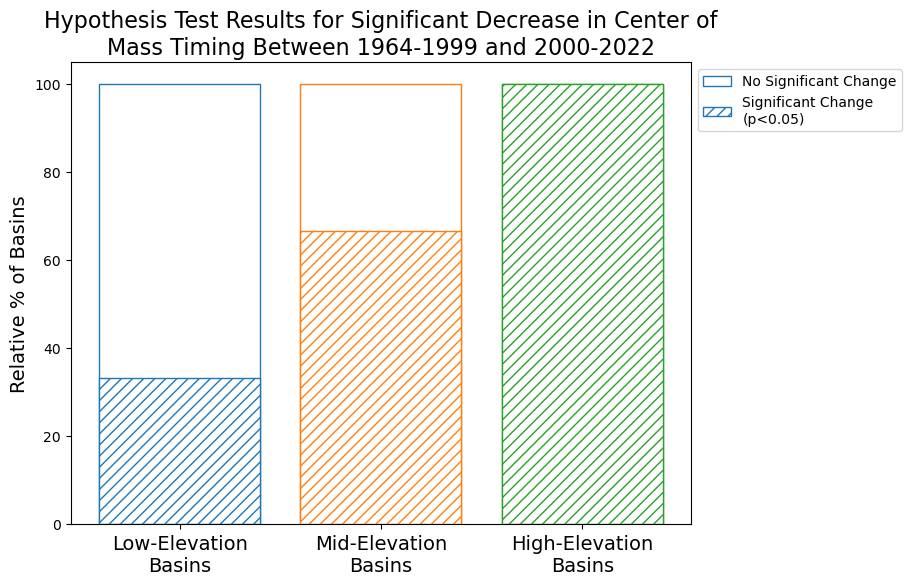

In [20]:

# create a dataframe with the results
low_rejected = len(low_com_ttest_results[(low_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_com_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_com_ttest_results[(mid_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_com_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_com_ttest_results[(high_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_com_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Center of\nMass Timing Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

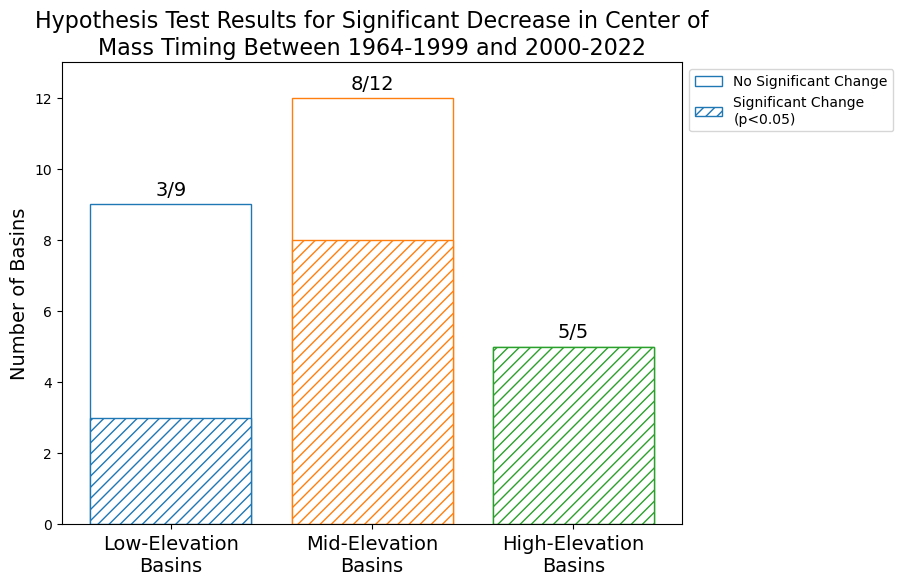

In [21]:
# create a dataframe with the results
low_rejected = len(low_com_ttest_results[(low_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_com_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_com_ttest_results[(mid_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_com_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_com_ttest_results[(high_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_com_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[9, 12, 5], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[(low_rejected), (mid_rejected), (high_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Center of\nMass Timing Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Hypothesis testing for change in annual mean flow between pre- and post-2000 periods

1) High Elevation Basins

In [22]:
high_meanq_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_q.site_no.values:
    single_site_pre = high_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[:1999]
    single_site_post = high_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [23]:
high_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.257247,Probably Gaussian,0.074,Null Hypothesis Accepted,NaN,NaN
09065500,0.179326,Probably Gaussian,0.094,Null Hypothesis Accepted,NaN,NaN
09066200,0.349053,Probably Gaussian,0.028,Null Hypothesis Rejected,NaN,NaN
09081600,0.084546,Probably Gaussian,0.053,Null Hypothesis Accepted,NaN,NaN
09352900,0.161308,Probably Gaussian,0.024,Null Hypothesis Rejected,NaN,NaN


2) Mid Elevation Basins

In [24]:
mid_meanq_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    single_site_pre = mid_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[:1999]
    single_site_post = mid_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        mid_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [25]:
mid_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.092024,Probably Gaussian,0.423,Null Hypothesis Accepted,NaN,NaN
09047700,0.00872,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.424,Null Hypothesis Accepted
09066000,0.377437,Probably Gaussian,0.151,Null Hypothesis Accepted,NaN,NaN
09066300,0.055656,Probably Gaussian,0.034,Null Hypothesis Rejected,NaN,NaN
09107000,0.129873,Probably Gaussian,0.121,Null Hypothesis Accepted,NaN,NaN
09110000,0.096248,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09112500,0.377518,Probably Gaussian,0.01,Null Hypothesis Rejected,NaN,NaN
09115500,0.185555,Probably Gaussian,0.107,Null Hypothesis Accepted,NaN,NaN
09124500,0.036675,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.081,Null Hypothesis Accepted
09146200,0.787195,Probably Gaussian,0.066,Null Hypothesis Accepted,NaN,NaN


3) Low Elevation Basins

In [26]:
low_meanq_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    single_site_pre = low_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[:1999]
    single_site_post = low_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [27]:
low_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.001538,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.03,Null Hypothesis Rejected
09132500,0.030177,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.038,Null Hypothesis Rejected
09147500,0.121565,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN
09183500,0.295278,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN
09210500,0.055539,Probably Gaussian,0.221,Null Hypothesis Accepted,NaN,NaN
09223000,0.378211,Probably Gaussian,0.032,Null Hypothesis Rejected,NaN,NaN
09239500,0.915084,Probably Gaussian,0.073,Null Hypothesis Accepted,NaN,NaN
09304500,0.409155,Probably Gaussian,0.01,Null Hypothesis Rejected,NaN,NaN
09312600,0.340267,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN


4. Upper Colorado River Basin

In [28]:
ucrb_meanq_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])

single_site_pre = ucrb_naturalized_streamflow['q_mm_day'].loc[:1999]
single_site_post = ucrb_naturalized_streamflow['q_mm_day'].loc[2000:2022]
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_meanq_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_meanq_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_meanq_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_meanq_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_meanq_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_meanq_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'

In [29]:
ucrb_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
UCRB,0.444077,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN


Annual Mean Flow Change Plots

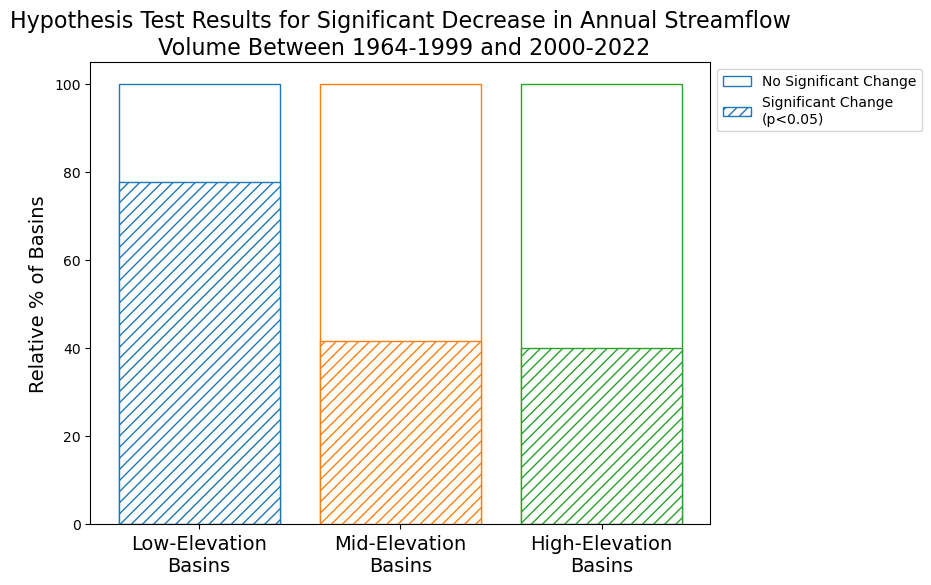

In [30]:

# create a dataframe with the results
low_rejected = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_meanq_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_meanq_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_meanq_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Annual Streamflow\n Volume Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

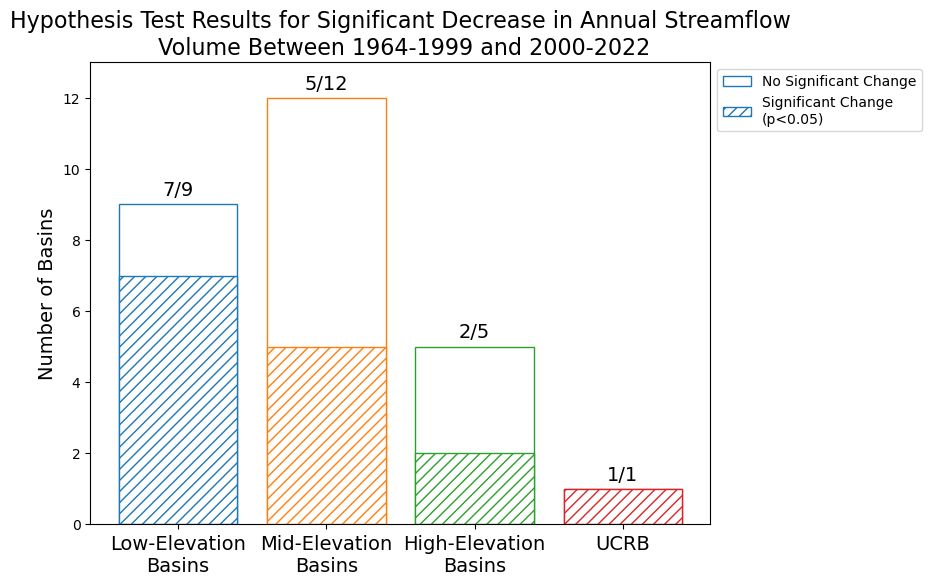

In [31]:
# create a dataframe with the results
low_rejected = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_meanq_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_meanq_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_meanq_ttest_results['mannwhitney p']<=0.05)])
ucrb_rejected = len(ucrb_meanq_ttest_results[(ucrb_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (ucrb_meanq_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Annual Streamflow\n Volume Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Hypothesis testing for change in the distribution of seasonal precipitation in pre- and post-2000 periods

1) High Elevation Basins

Text(0.5, 1.0, 'Summer')

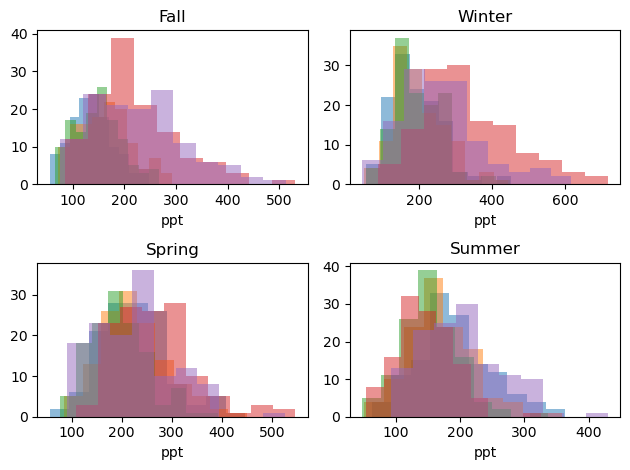

In [32]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in high_elevation_seasonal_ppt.site_no:
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==9,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==12,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==3,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==6,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [33]:
high_winterp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [34]:
high_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.015406,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.643,Null Hypothesis Accepted
09065500,0.021293,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.487,Null Hypothesis Accepted
09066200,0.03624,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.551,Null Hypothesis Accepted
09081600,0.190298,Probably Gaussian,0.17,Null Hypothesis Accepted,NaN,NaN
09352900,0.104066,Probably Gaussian,0.57,Null Hypothesis Accepted,NaN,NaN


In [35]:
high_springp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [36]:
high_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.454058,Probably Gaussian,0.336,Null Hypothesis Accepted,NaN,NaN
09065500,0.297046,Probably Gaussian,0.407,Null Hypothesis Accepted,NaN,NaN
09066200,0.655665,Probably Gaussian,0.727,Null Hypothesis Accepted,NaN,NaN
09081600,0.542348,Probably Gaussian,0.036,Null Hypothesis Rejected,NaN,NaN
09352900,0.030595,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.005,Null Hypothesis Rejected


In [37]:
high_summerp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        high_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            high_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [38]:
high_summerp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.474125,Probably Gaussian,0.752,Null Hypothesis Accepted,NaN,NaN
09065500,0.769866,Probably Gaussian,0.712,Null Hypothesis Accepted,NaN,NaN
09066200,0.38685,Probably Gaussian,0.736,Null Hypothesis Accepted,NaN,NaN
09081600,0.190672,Probably Gaussian,0.718,Null Hypothesis Accepted,NaN,NaN
09352900,0.997132,Probably Gaussian,0.998,Null Hypothesis Rejected,NaN,NaN


2) Mid Elevation Basins

Text(0.5, 1.0, 'Summer')

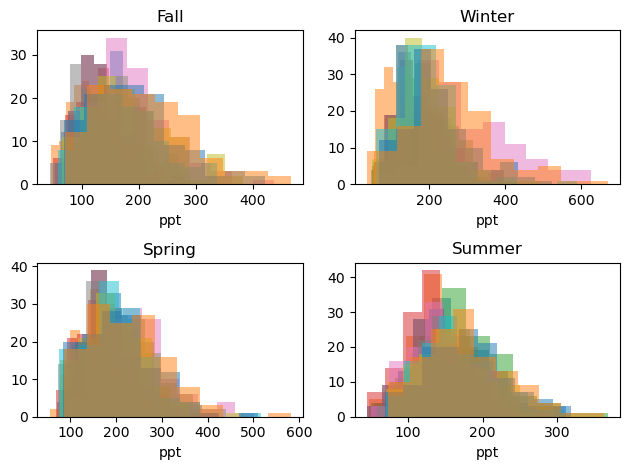

In [39]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in mid_elevation_seasonal_ppt.site_no:
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==9,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==12,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==3,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==6,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [40]:
mid_winterp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [41]:
mid_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.040913,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.732,Null Hypothesis Accepted
09047700,0.056199,Probably Gaussian,0.923,Null Hypothesis Accepted,NaN,NaN
09066000,0.032856,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.544,Null Hypothesis Accepted
09066300,0.05573,Probably Gaussian,0.818,Null Hypothesis Accepted,NaN,NaN
09107000,0.108213,Probably Gaussian,0.472,Null Hypothesis Accepted,NaN,NaN
09110000,0.108213,Probably Gaussian,0.472,Null Hypothesis Accepted,NaN,NaN
09112500,0.232483,Probably Gaussian,0.162,Null Hypothesis Accepted,NaN,NaN
09115500,0.240446,Probably Gaussian,0.405,Null Hypothesis Accepted,NaN,NaN
09124500,0.184203,Probably Gaussian,0.608,Null Hypothesis Accepted,NaN,NaN
09146200,0.090934,Probably Gaussian,0.663,Null Hypothesis Accepted,NaN,NaN


In [42]:
mid_springp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [43]:
mid_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.405961,Probably Gaussian,0.432,Null Hypothesis Accepted,NaN,NaN
09047700,0.992164,Probably Gaussian,0.811,Null Hypothesis Accepted,NaN,NaN
09066000,0.407434,Probably Gaussian,0.327,Null Hypothesis Accepted,NaN,NaN
09066300,0.773366,Probably Gaussian,0.791,Null Hypothesis Accepted,NaN,NaN
09107000,0.197993,Probably Gaussian,0.024,Null Hypothesis Rejected,NaN,NaN
09110000,0.197993,Probably Gaussian,0.024,Null Hypothesis Rejected,NaN,NaN
09112500,0.455568,Probably Gaussian,0.01,Null Hypothesis Rejected,NaN,NaN
09115500,0.736565,Probably Gaussian,0.051,Null Hypothesis Accepted,NaN,NaN
09124500,0.043958,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.024,Null Hypothesis Rejected
09146200,0.037886,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.036,Null Hypothesis Rejected


In [44]:
mid_summerp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        mid_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            mid_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [45]:
mid_summerp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.807208,Probably Gaussian,0.831,Null Hypothesis Accepted,NaN,NaN
09047700,0.807315,Probably Gaussian,0.614,Null Hypothesis Accepted,NaN,NaN
09066000,0.465271,Probably Gaussian,0.62,Null Hypothesis Accepted,NaN,NaN
09066300,0.345525,Probably Gaussian,0.49,Null Hypothesis Accepted,NaN,NaN
09107000,0.298156,Probably Gaussian,0.779,Null Hypothesis Accepted,NaN,NaN
09110000,0.298156,Probably Gaussian,0.779,Null Hypothesis Accepted,NaN,NaN
09112500,0.211961,Probably Gaussian,0.822,Null Hypothesis Accepted,NaN,NaN
09115500,0.138325,Probably Gaussian,0.969,Null Hypothesis Rejected,NaN,NaN
09124500,0.593709,Probably Gaussian,0.961,Null Hypothesis Rejected,NaN,NaN
09146200,0.551606,Probably Gaussian,0.959,Null Hypothesis Rejected,NaN,NaN


3) Low Elevation Basins

Text(0.5, 1.0, 'Summer')

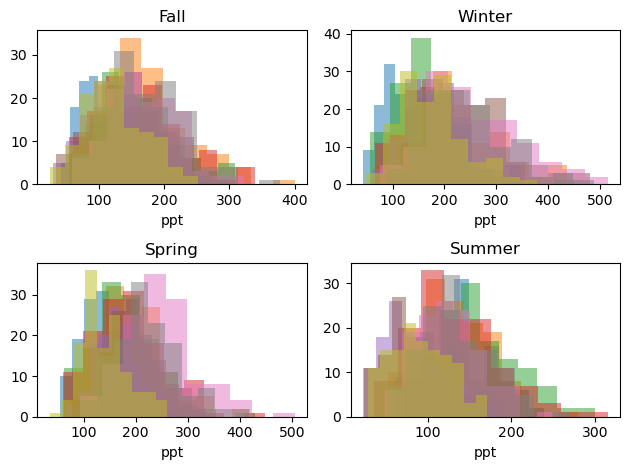

In [46]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in low_elevation_seasonal_ppt.site_no:
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==9,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==12,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==3,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==6,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [47]:
low_winterp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==12, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [48]:
low_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.285837,Probably Gaussian,0.58,Null Hypothesis Accepted,NaN,NaN
09132500,0.101126,Probably Gaussian,0.42,Null Hypothesis Accepted,NaN,NaN
09147500,0.172244,Probably Gaussian,0.714,Null Hypothesis Accepted,NaN,NaN
09183500,0.254451,Probably Gaussian,0.183,Null Hypothesis Accepted,NaN,NaN
09210500,0.159909,Probably Gaussian,0.26,Null Hypothesis Accepted,NaN,NaN
09223000,0.173651,Probably Gaussian,0.227,Null Hypothesis Accepted,NaN,NaN
09239500,0.080024,Probably Gaussian,0.238,Null Hypothesis Accepted,NaN,NaN
09304500,0.212276,Probably Gaussian,0.022,Null Hypothesis Rejected,NaN,NaN
09312600,0.104914,Probably Gaussian,0.477,Null Hypothesis Accepted,NaN,NaN


In [49]:
low_springp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==3, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [50]:
low_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.196644,Probably Gaussian,0.028,Null Hypothesis Rejected,NaN,NaN
09132500,0.527192,Probably Gaussian,0.067,Null Hypothesis Accepted,NaN,NaN
09147500,0.050036,Probably Gaussian,0.049,Null Hypothesis Rejected,NaN,NaN
09183500,0.22965,Probably Gaussian,0.016,Null Hypothesis Rejected,NaN,NaN
09210500,0.048426,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.195,Null Hypothesis Accepted
09223000,0.029188,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.273,Null Hypothesis Accepted
09239500,0.34345,Probably Gaussian,0.075,Null Hypothesis Accepted,NaN,NaN
09304500,0.866332,Probably Gaussian,0.017,Null Hypothesis Rejected,NaN,NaN
09312600,0.501572,Probably Gaussian,0.088,Null Hypothesis Accepted,NaN,NaN


In [51]:
low_summerp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = np.log(low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==6, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(1-conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        low_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            low_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        low_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value >1-conf:
            low_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [52]:
low_summerp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.124402,Probably Gaussian,0.981,Null Hypothesis Rejected,NaN,NaN
09132500,0.41627,Probably Gaussian,0.727,Null Hypothesis Accepted,NaN,NaN
09147500,0.615937,Probably Gaussian,0.969,Null Hypothesis Rejected,NaN,NaN
09183500,0.926014,Probably Gaussian,0.873,Null Hypothesis Accepted,NaN,NaN
09210500,0.068048,Probably Gaussian,0.998,Null Hypothesis Rejected,NaN,NaN
09223000,0.057738,Probably Gaussian,0.991,Null Hypothesis Rejected,NaN,NaN
09239500,0.69701,Probably Gaussian,0.969,Null Hypothesis Rejected,NaN,NaN
09304500,0.827898,Probably Gaussian,0.955,Null Hypothesis Rejected,NaN,NaN
09312600,0.163344,Probably Gaussian,0.898,Null Hypothesis Accepted,NaN,NaN


4. Upper Colorado River Basin

In [53]:
# Seasonal Precipitation Plot
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.month.dt.days_in_month

    # Calculate the weighted average
    return (ds).resample(month='QS-DEC').mean() * 3

In [54]:
ucrb_ppt_seasonal_mean = season_mean(p_mean.drop('WY'))
ucrb_ppt_seasonal_mean['WY'] = ucrb_ppt_seasonal_mean.month.dt.year.where(ucrb_ppt_seasonal_mean.month.dt.month<10, ucrb_ppt_seasonal_mean.month.dt.year+1)

Text(0.5, 1.0, 'Summer')

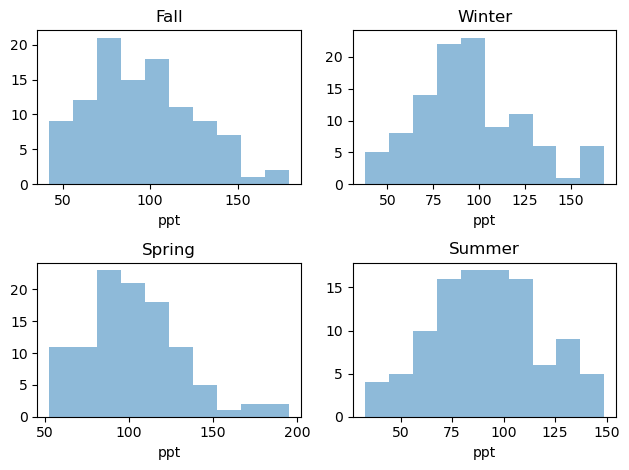

In [55]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()

ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==9),drop=True)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==12),drop=True)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==3),drop=True)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==6),drop=True)['ppt'].plot.hist(ax=axs[3], alpha=0.5)

axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [56]:
season_list = ['fall','winter','spring','summer']
ucrb_seasonalppt_ttest_results = pd.DataFrame(index=season_list, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
seasons = [ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==9),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==12),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==3),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==6),drop=True)['ppt'].to_pandas()]
for i,ds_seas in enumerate(seasons):
    single_site_pre = np.log(ds_seas.loc[dt.date(test_start_year,9,30):dt.date(1999,9,30)])
    single_site_post = np.log(ds_seas.loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke p'] = p

    if p > conf:
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke Result'] = 'Probably Gaussian'
        if season_list[i] =='summer':
            # run the test for 1-conf
            z_alpha = stats.norm.ppf(1-conf)
        else:
            z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        if season_list[i] =='summer':
            # run the test for 1-conf
            pvalue = 1-stats.norm.cdf(z_test)
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test p'] = np.round(pvalue,3)
            if pvalue > 1-conf:
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Rejected'
            else: 
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Accepted'
        else:
            pvalue = stats.norm.cdf(z_test)
        
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test p'] = np.round(pvalue,3)
            if pvalue < conf:
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Rejected'
            else: 
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        if season_list[i] =='summer':
            stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        else:
            stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [57]:
ucrb_seasonalppt_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
fall,0.383471,Probably Gaussian,0.263,Null Hypothesis Accepted,NaN,NaN
winter,0.08912,Probably Gaussian,0.542,Null Hypothesis Accepted,NaN,NaN
spring,0.413842,Probably Gaussian,0.046,Null Hypothesis Rejected,NaN,NaN
summer,0.593678,Probably Gaussian,0.987,Null Hypothesis Rejected,NaN,NaN


### Winter Precipitation Shift Results

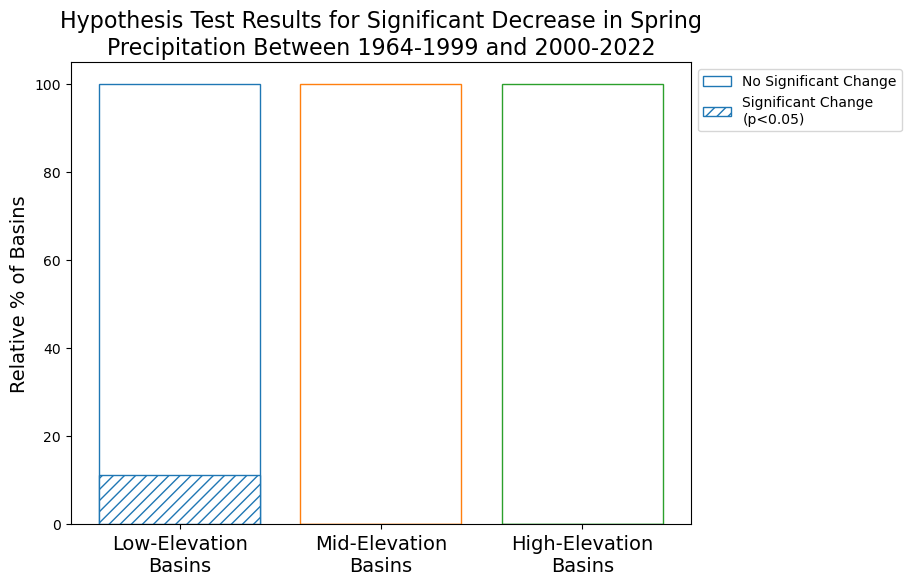

In [58]:

# create a dataframe with the results
low_rejected = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_winterp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_winterp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_winterp_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

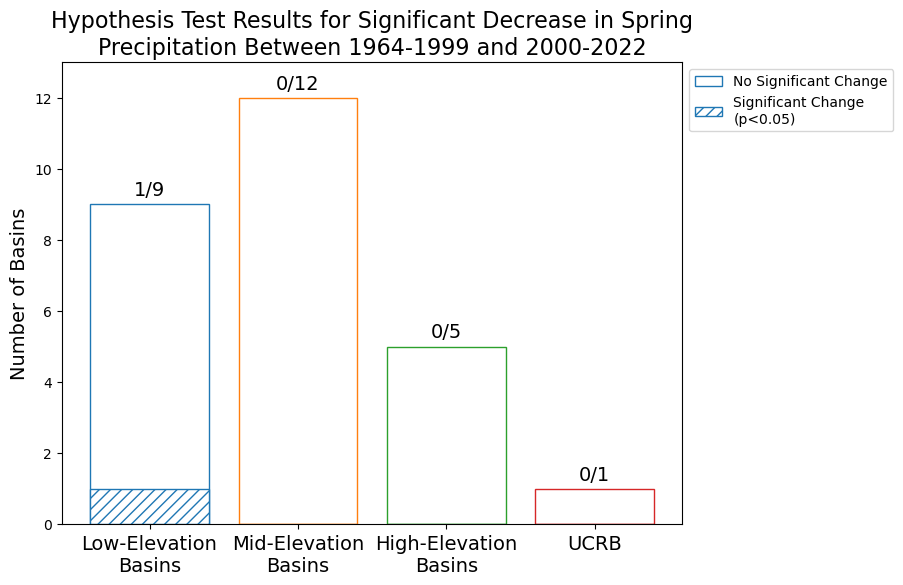

In [59]:
# create a dataframe with the results
low_rejected = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_winterp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_winterp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_winterp_ttest_results['mannwhitney p']<=0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='winter']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Spring Precipitation Shift Results

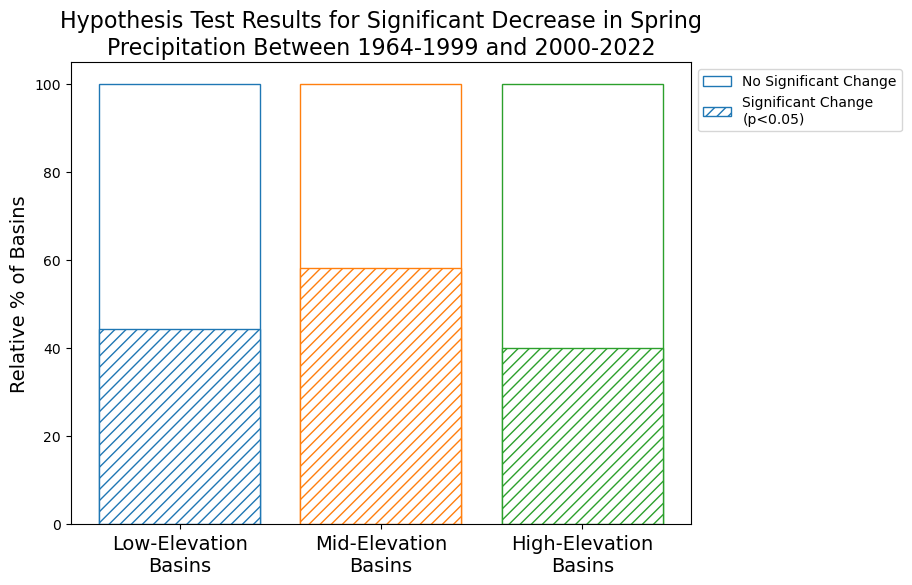

In [60]:

# create a dataframe with the results
low_rejected = len(low_springp_ttest_results[(low_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_springp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_springp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_springp_ttest_results[(high_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_springp_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

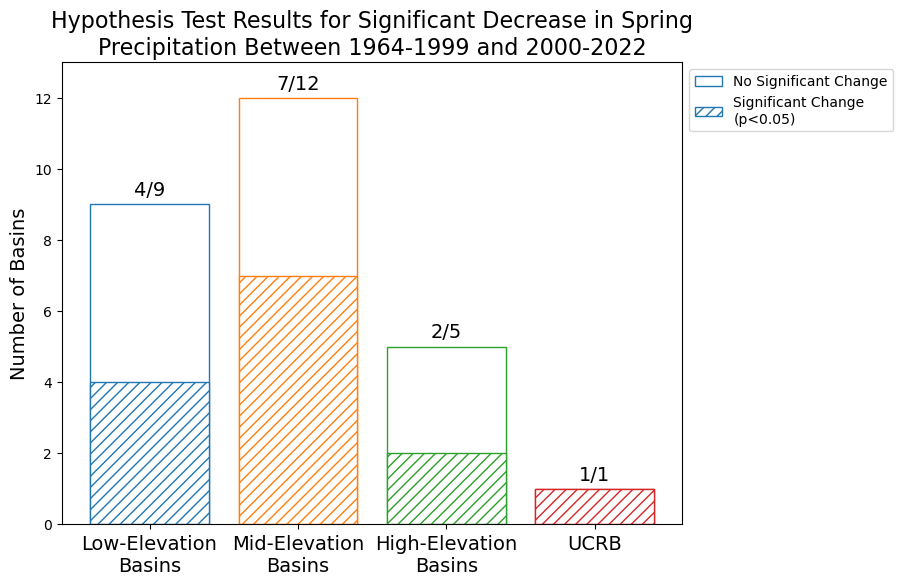

In [61]:
# create a dataframe with the results
low_rejected = len(low_springp_ttest_results[(low_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_springp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_springp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_springp_ttest_results[(high_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_springp_ttest_results['mannwhitney p']<=0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='spring']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Summer Precipitation Shift Results

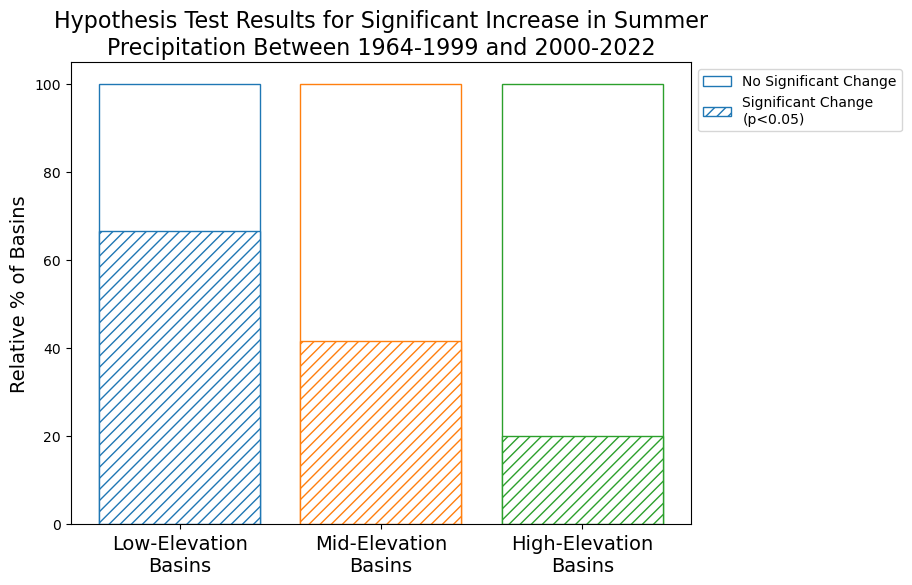

In [62]:

# create a dataframe with the results
low_rejected = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Increase in Summer\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

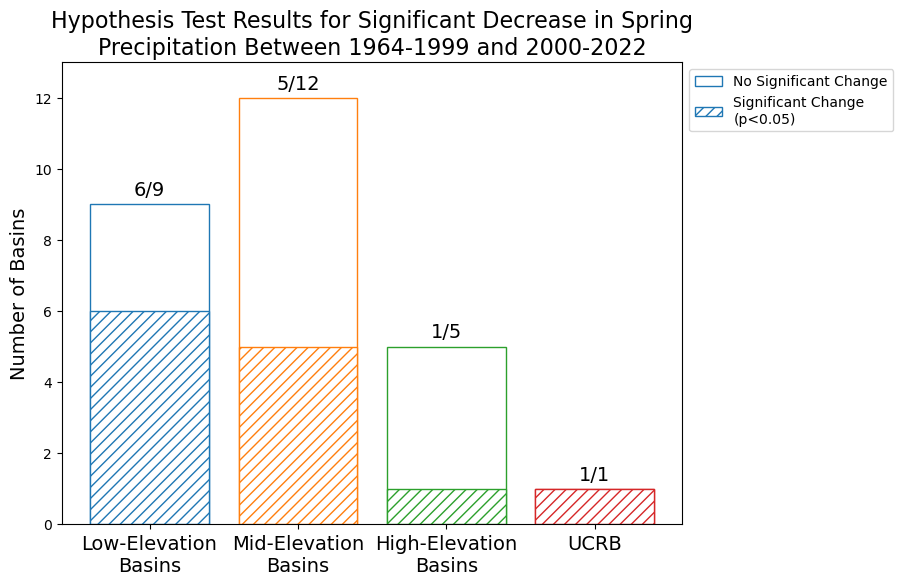

In [63]:
# create a dataframe with the results
low_rejected = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='summer']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### Hypothesis testing for change in the amount of annual precipitation in pre- and post-2000 periods

1) High Elevation Basins

In [64]:
high_annualp_ttest_results = pd.DataFrame(index=high_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_elevation_annual_ppt.site_no.values:
    minyear = high_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(high_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = np.log(high_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [65]:
high_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.43211,Probably Gaussian,0.413,Null Hypothesis Accepted,NaN,NaN
09065500,0.99996,Probably Gaussian,0.376,Null Hypothesis Accepted,NaN,NaN
09066200,0.999776,Probably Gaussian,0.657,Null Hypothesis Accepted,NaN,NaN
09081600,0.224206,Probably Gaussian,0.009,Null Hypothesis Rejected,NaN,NaN
09352900,0.642495,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN


2) Mid Elevation Basins

In [66]:
mid_annualp_ttest_results = pd.DataFrame(index=mid_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in mid_elevation_annual_ppt.site_no.values:
    minyear = mid_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(mid_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = np.log(mid_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [67]:
mid_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.989459,Probably Gaussian,0.477,Null Hypothesis Accepted,NaN,NaN
09047700,0.54951,Probably Gaussian,0.782,Null Hypothesis Accepted,NaN,NaN
09066000,0.987515,Probably Gaussian,0.37,Null Hypothesis Accepted,NaN,NaN
09066300,0.995973,Probably Gaussian,0.849,Null Hypothesis Accepted,NaN,NaN
09107000,0.519758,Probably Gaussian,0.038,Null Hypothesis Rejected,NaN,NaN
09110000,0.519758,Probably Gaussian,0.038,Null Hypothesis Rejected,NaN,NaN
09112500,0.284844,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN
09115500,0.371448,Probably Gaussian,0.011,Null Hypothesis Rejected,NaN,NaN
09124500,0.8139,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN
09146200,0.571617,Probably Gaussian,0.01,Null Hypothesis Rejected,NaN,NaN


3) Low Elevation Basins

In [68]:
low_annualp_ttest_results = pd.DataFrame(index=low_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_elevation_annual_ppt.site_no.values:
    minyear = low_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = np.log(low_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = np.log(low_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        low_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [69]:
low_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09119000,0.877872,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN
09132500,0.309611,Probably Gaussian,0.034,Null Hypothesis Rejected,NaN,NaN
09147500,0.596179,Probably Gaussian,0.008,Null Hypothesis Rejected,NaN,NaN
09183500,0.985987,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN
09210500,0.208691,Probably Gaussian,0.031,Null Hypothesis Rejected,NaN,NaN
09223000,0.286247,Probably Gaussian,0.042,Null Hypothesis Rejected,NaN,NaN
09239500,0.294036,Probably Gaussian,0.025,Null Hypothesis Rejected,NaN,NaN
09304500,0.265511,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN
09312600,0.271108,Probably Gaussian,0.104,Null Hypothesis Accepted,NaN,NaN


4. Upper Colorado River Basin

In [70]:
ucrb_annual_ppt = ucrb_ppt_seasonal_mean.groupby('WY').sum()
ucrb_annual_ppt_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p'
                                                                                    ])
single_site_pre = np.log(ucrb_annual_ppt['ppt'].to_pandas().loc[1905:1999])
single_site_post = np.log(ucrb_annual_ppt['ppt'].to_pandas().loc[2000:])
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_annual_ppt_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_annual_ppt_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_annual_ppt_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'

In [71]:
ucrb_annual_ppt_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p
UCRB,0.84251,Probably Gaussian,0.057,Null Hypothesis Accepted,NaN


Annual Precipitation Shift Plots

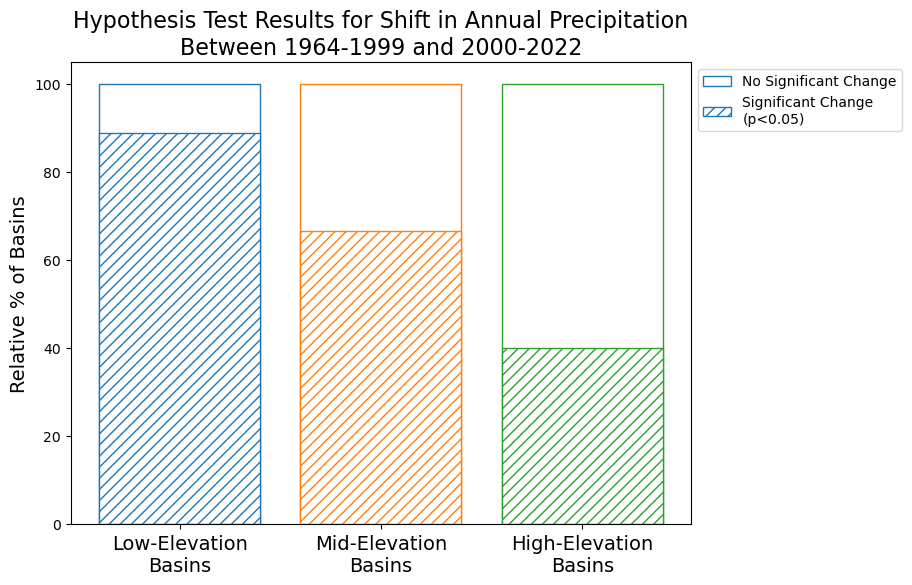

In [72]:

# create a dataframe with the results
low_rejected = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_annualp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_annualp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_annualp_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Shift in Annual Precipitation\nBetween {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)

(0.0, 13.0)

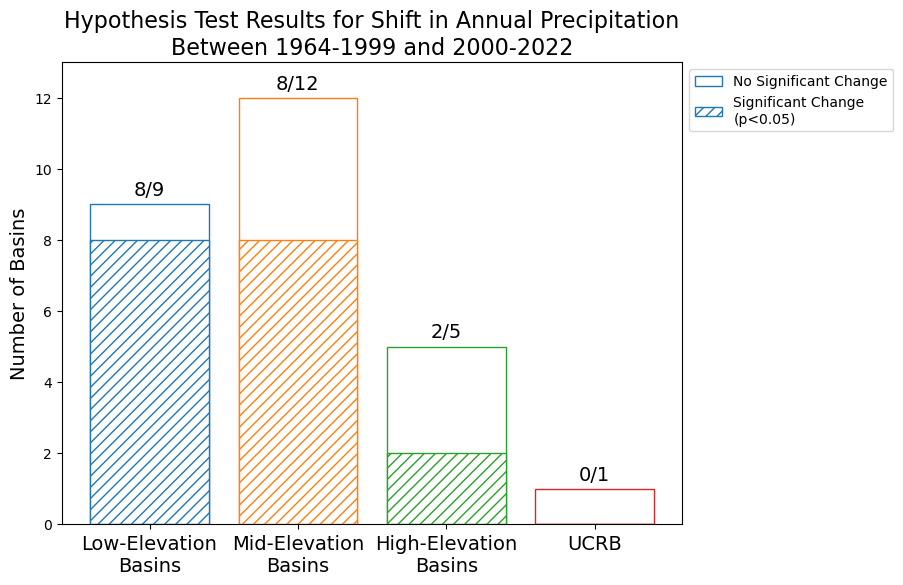

In [73]:

# create a dataframe with the results
low_rejected = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_annualp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_annualp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_annualp_ttest_results['mannwhitney p']<0.05)])
ucrb_rejected = len(ucrb_annual_ppt_ttest_results[(ucrb_annual_ppt_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (ucrb_annual_ppt_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[9, 12, 5, 1], 
       ec=['#1f77b4','#ff7f0e','#2ca02c', '#d62728'], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], 
       color=['white','white','white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Shift in Annual Precipitation\nBetween {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=9.25, s=f'{low_rejected}/9', fontsize=14, ha='center')
ax.text(x=1, y=12.25, s=f'{mid_rejected}/12', fontsize=14, ha='center')
ax.text(x=2, y=5.25, s=f'{high_rejected}/5', fontsize=14, ha='center')
ax.text(x=3, y=1.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center')
ax.set_ylim(0,13)

### ANOVA testing for differences between basins in pre- and post-2000 streamflow

In [74]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
dates = [date2DOWY(x) for x in hcdn_daily_q.date.values]
dowy_da = pd.Series(dates,index=hcdn_daily_q.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_ds = hcdn_daily_q.copy()
hcdn_q_dowy_ds = hcdn_q_dowy_ds.merge(dowy_da)
hcdn_q_dowy_spsu_ds = hcdn_q_dowy_ds.where(hcdn_q_dowy_ds.date.dt.month.isin([3,4,5,6,7,8,9,10]), drop=True)

In [75]:
hcdn_q_dowy_pre2000_ds = hcdn_q_dowy_spsu_ds.where(hcdn_q_dowy_spsu_ds.WY<2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_q_dowy_pre2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_q_dowy_pre2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_pre2000_ds = hcdn_q_dowy_pre2000_ds.merge(dowy_da)

In [76]:
hcdn_q_dowy_post2000_ds = hcdn_q_dowy_spsu_ds.where(hcdn_q_dowy_spsu_ds.WY>=2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_q_dowy_post2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_q_dowy_post2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_post2000_ds = hcdn_q_dowy_post2000_ds.merge(dowy_da)

In [77]:
hcdn_q_dowy_mean = hcdn_q_dowy_spsu_ds.groupby('dowy').mean()
hcdn_q_dowy_pre2000_mean = hcdn_q_dowy_pre2000_ds.groupby('dowy').mean()
hcdn_q_dowy_post2000_mean = hcdn_q_dowy_post2000_ds.groupby('dowy').mean()

6.378322826263686
0.0017934681352298782


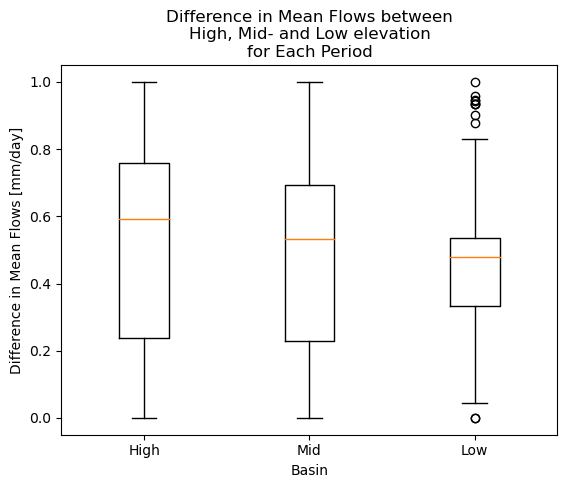

In [78]:
site_diff_high = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==2, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==2, drop=True).mean(dim='site_no')['q_mm_day']))
site_diff_mid = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==0, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==0, drop=True).mean(dim='site_no')['q_mm_day']))
site_diff_low = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==1, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==1, drop=True).mean(dim='site_no')['q_mm_day']))
# stats f_oneway functions takes the groups as input and returns an F and P-value
fvalue, pvalue = stats.f_oneway(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
                                ((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
                                ((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min())))
print(fvalue)
print(pvalue)
# Using boxplot, we can start to visually see differences between the periods
plt.boxplot([((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
                ((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
                ((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))],
           labels=['High', 'Mid', 'Low'])

# Add labels
plt.xlabel('Basin')
plt.ylabel('Difference in Mean Flows [mm/day]')
plt.title('Difference in Mean Flows between\nHigh, Mid- and Low elevation\nfor Each Period');

Prior to running our test, lets test to make sure our data is valid for using this test

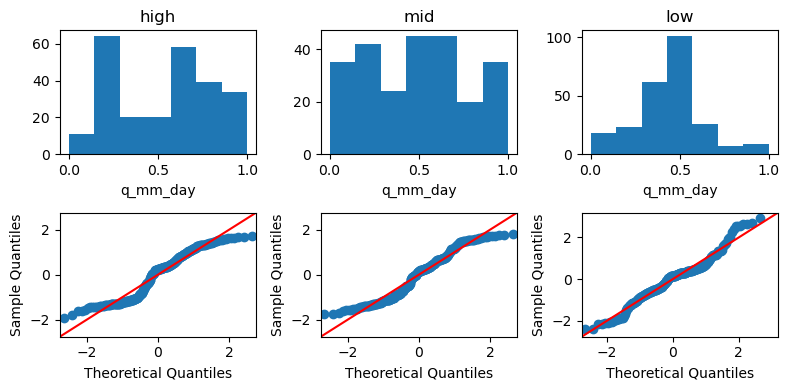

In [79]:
# test for normality 
fig, axs = plt.subplots(ncols=3, nrows=2, tight_layout=True, figsize=(8,4))
val_list = [((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))]
val_title =['high', 'mid', 'low']
for i, val in enumerate(val_list):
    val.plot.hist(ax=axs[0,i], bins=7)
    axs[0,i].set_title(val_title[i])

    sm.qqplot((val-val.mean())/val.std(), line ='45', ax=axs[1,i]);


Fails the Bartlett test which tests for equal variance

In [80]:
stats.bartlett(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min()))),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))

<xarray.DataArray 'q_mm_day' (dowy: 246)>
array([5.74392642e-01, 6.10382086e-01, 5.32735608e-01, 5.48752500e-01,
       5.52848543e-01, 6.49761675e-01, 6.25743972e-01, 5.48043096e-01,
       5.42409552e-01, 5.55183914e-01, 5.38633840e-01, 5.12146445e-01,
       4.53781281e-01, 5.04695064e-01, 5.19257414e-01, 4.93173381e-01,
       5.21223085e-01, 5.00570658e-01, 4.77851782e-01, 5.08511567e-01,
       5.05160446e-01, 5.27233602e-01, 5.43152687e-01, 5.24693671e-01,
       5.54807201e-01, 5.56958273e-01, 4.55596803e-01, 5.01233233e-01,
       5.21936585e-01, 5.00693131e-01, 4.81098891e-01, 4.05564235e-01,
       4.63092784e-01, 4.75336861e-01, 4.89353588e-01, 4.88633406e-01,
       5.05853234e-01, 5.22440682e-01, 5.40848085e-01, 4.99150947e-01,
       5.00686326e-01, 5.18026746e-01, 5.74013440e-01, 6.67911612e-01,
       7.07211054e-01, 7.58491080e-01, 7.72177569e-01, 8.25277054e-01,
       8.76951468e-01, 9.34015440e-01, 9.33494270e-01, 9.44681241e-01,
       9.57182681e-01, 1.00000000e+00, 9.44892337e-01, 9.33581598e-01,
       9.02807025e-01, 8.30691566e-01, 8.11327901e-01, 7.69230691e-01,
       7.47066173e-01, 7.07741794e-01, 6.67326626e-01, 7.09955887e-01,
       7.04207275e-01, 6.32396148e-01, 6.07009574e-01, 6.23192068e-01,
       5.82116227e-01, 6.59391986e-01, 6.66665810e-01, 7.00052562e-01,
       6.75871958e-01, 6.47451194e-01, 6.63145113e-01, 6.76602917e-01,
       6.69313293e-01, 6.04372200e-01, 5.54778243e-01, 5.20564392e-01,
...
       3.10778287e-01, 3.21526349e-01, 3.31106695e-01, 3.28851284e-01,
       3.34987504e-01, 3.24783743e-01, 3.42935157e-01, 3.29005915e-01,
       3.47080171e-01, 3.81237676e-01, 4.32553549e-01, 3.87985222e-01,
       3.91438908e-01, 3.99389645e-01, 4.29811072e-01, 4.15404634e-01,
       4.20271092e-01, 4.69481501e-01, 4.81375513e-01, 5.83598832e-01,
       5.22846711e-01, 5.33514348e-01, 5.06003862e-01, 4.85119262e-01,
       5.66076414e-01, 5.32847871e-01, 5.30654413e-01, 4.90580629e-01,
       5.01359947e-01, 5.01506294e-01, 5.36731121e-01, 5.22691326e-01,
       5.24561818e-01, 4.77840234e-01, 4.89033695e-01, 5.89798460e-01,
       4.79447273e-01, 4.79155145e-01, 5.06381031e-01, 4.97886945e-01,
       4.86847737e-01, 5.10283972e-01, 5.42391176e-01, 4.80960321e-01,
       5.16693974e-01, 4.72724473e-01, 4.93211119e-01, 5.10129474e-01,
       5.07604679e-01, 5.06619341e-01, 4.70805619e-01, 5.02367330e-01,
       4.41130469e-01, 3.99521486e-01, 4.34111647e-01, 5.25200369e-01,
       5.60686913e-01, 4.91002666e-01, 4.03094146e-01, 3.49517431e-01,
       3.55696355e-01, 4.58325322e-01, 4.14460135e-01, 4.33264388e-01,
       3.30133639e-01, 3.48490890e-01, 3.06206525e-01, 2.82726773e-01,
       3.66936479e-01, 4.80386079e-01, 4.03298033e-01, 3.61203825e-01,
       3.53705621e-01, 3.66870765e-01, 4.84293811e-01, 4.79282562e-01,
       4.47758002e-01, 3.11576919e-01])
Coordinates:
  * dowy     (dowy) float64 0.0 1.0 2.0 3.0 4.0 ... 362.0 363.0 364.0 365.0

In [81]:
site_diff_high['elevation_cluster'] = 'high'
site_diff_mid['elevation_cluster'] = 'mid'
site_diff_low['elevation_cluster'] = 'low'

In [82]:
df_reshaped = pd.concat([site_diff_high.to_dataframe()[['elevation_cluster','q_mm_day']], 
                         site_diff_mid.to_dataframe()[['elevation_cluster','q_mm_day']],
                         site_diff_low.to_dataframe()[['elevation_cluster','q_mm_day']], 
                         ]).reset_index()
# perform multiple pairwise comparison (Tukey HSD), 
# endog is response variable, groups are the tested groups to compare
period_comp = pairwise_tukeyhsd(endog=df_reshaped['q_mm_day'], groups=df_reshaped['elevation_cluster'], alpha=0.05)

# display the results table
print(period_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  high    low  -0.0724 0.0001 -0.1117 -0.033   True
  high    mid  -0.0233 0.3468 -0.0626 0.0161  False
   low    mid   0.0491 0.0098  0.0097 0.0884   True
---------------------------------------------------


The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.

In [83]:
stats.kruskal(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min())))

KruskalResult(statistic=13.579860214429296, pvalue=0.0011250474041236997)